In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score

In [3]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer

In [4]:
training_data=pd.read_csv('data/jigsaw-toxic-comment-classification/train.csv')
testing_data=pd.read_csv('data/jigsaw-toxic-comment-classification/test.csv')

In [5]:
print(training_data.shape,testing_data.shape)

(159571, 8) (153164, 2)


In [6]:
training_data[:3]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0


In [7]:
training_data['comment_text'][4]

"You, sir, are my hero. Any chance you remember what page that's on?"

In [8]:
length=training_data.comment_text.str.len()
length.max(), length.mean()

(5000, 394.138847284281)

In [9]:
training_data.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
training_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [11]:
df_data=training_data.drop(['id','comment_text'],axis=1)
counts=[]
categories=df_data.columns.values
for i in categories:
    counts.append((i,df_data[i].sum()))
stats=pd.DataFrame(counts,columns=['category','number_of_comments'])
stats

,category,number_of_comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


Text(0, 0.5, 'number of occurrences')

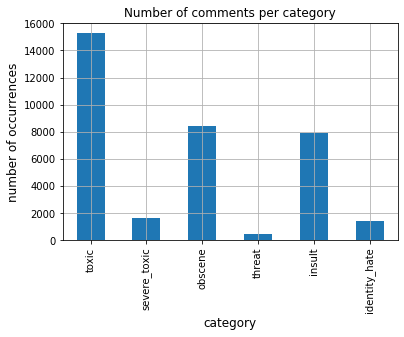

In [12]:
stats.plot(x='category',y='number_of_comments',kind='bar',legend=False,grid=True,figsize=(6,4))
plt.title("Number of comments per category")
plt.xlabel('category',fontsize=12)
plt.ylabel('number of occurrences',fontsize=12)

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
dtype: int64

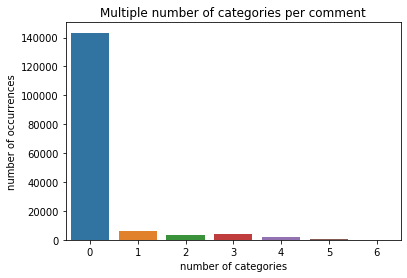

In [13]:
sum_of_rows=training_data.iloc[:,2:].sum(axis=1)
x=sum_of_rows.value_counts()
plt.plot(figsize=(8,6))
sns.barplot(x.index,x.values)
plt.title("Multiple number of categories per comment")
plt.xlabel("number of categories",fontsize=10)
plt.ylabel("number of occurrences",fontsize=10)
x

In [14]:
print("percentage of comments that are unlabelled")
print(100*len(training_data[(training_data['toxic']==0)&(training_data['severe_toxic']==0)&(training_data['obscene']==0)&(training_data['threat']==0)&(training_data['insult']==0)&(training_data['identity_hate']==0)])/(len(training_data)))

percentage of comments that are unlabelled
89.83211235124176


In [15]:
print("missing comments")
training_data['comment_text'].isnull().sum()

missing comments


0

In [16]:
training_data['comment_text'][15]

'"\n\nJuelz Santanas Age\n\nIn 2002, Juelz Santana was 18 years old, then came February 18th, which makes Juelz turn 19 making songs with The Diplomats. The third neff to be signed to Cam\'s label under Roc A Fella. In 2003, he was 20 years old coming out with his own singles ""Santana\'s Town"" and ""Down"". So yes, he is born in 1983. He really is, how could he be older then Lloyd Banks? And how could he be 22 when his birthday passed? The homie neff is 23 years old. 1983 - 2006 (Juelz death, god forbid if your thinking about that) equals 23. Go to your caculator and stop changing his year of birth. My god."'

In [17]:
def clean_text(text):
    text=text.lower()
    text=re.sub(r"[^A-Za-z0-9]", " ", text)
    text=re.sub(r"can't","can not",text)
    text=re.sub(r"weren't","were not",text)
    text=re.sub(r"i'm","i am",text)
    text=re.sub(r"it's","it is",text)
    text=re.sub(r"\'s", " ", text)
    text=re.sub(r"\'ve", " have ",text)
    text=re.sub(r"n't", " not ",text)
    text=re.sub(r"\'re", " are ",text)
    text=re.sub(r"\'d", " would ",text)
    text=re.sub(r"\'ll", " will ",text)
    text=re.sub(r"\'scuse", " excuse ",text)
    text=re.sub(r"\n","",text)
    text=text.strip()
    return text

In [18]:
training_data['comment_text']=training_data['comment_text'].map(lambda comment : clean_text(comment))
training_data['comment_text'][15]

'juelz santanas age  in 2002  juelz santana was 18 years old  then came february 18th  which makes juelz turn 19 making songs with the diplomats  the third neff to be signed to cam s label under roc a fella  in 2003  he was 20 years old coming out with his own singles   santana s town   and   down    so yes  he is born in 1983  he really is  how could he be older then lloyd banks  and how could he be 22 when his birthday passed  the homie neff is 23 years old  1983   2006  juelz death  god forbid if your thinking about that  equals 23  go to your caculator and stop changing his year of birth  my god'

In [19]:
stop_words=set(stopwords.words('english'))
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [20]:
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','could','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
def removeStopWords(text):
    global re_stop_words
    return re_stop_words.sub(" ", text)
training_data['comment_text'] = training_data['comment_text'].apply(removeStopWords)

In [21]:
training_data['comment_text'][15]

'juelz santanas age   2002  juelz santana  18 years old   came february 18th   makes juelz turn 19 making songs   diplomats   third neff   signed  cam  label  roc  fella   2003    20 years old coming     singles   santana  town           yes    born  1983   really       older  lloyd banks       22   birthday passed   homie neff  23 years old  1983   2006  juelz death  god forbid   thinking    equals 23  go   caculator  stop changing  year  birth   god'

In [22]:
lemmatizer=WordNetLemmatizer()
def word_lemmatize(text):
    lemmSentence= ""
    for word in text.split():
        lemm= lemmatizer.lemmatize(word)
        lemmSentence+= lemm
        lemmSentence+= " "
    lemmSentence=lemmSentence.strip()
    return lemmSentence
training_data['comment_text'] = training_data['comment_text'].apply(word_lemmatize)

In [23]:
training_data['comment_text'][15]

'juelz santanas age 2002 juelz santana 18 year old came february 18th make juelz turn 19 making song diplomat third neff signed cam label roc fella 2003 20 year old coming single santana town yes born 1983 really older lloyd bank 22 birthday passed homie neff 23 year old 1983 2006 juelz death god forbid thinking equal 23 go caculator stop changing year birth god'

In [24]:
stemmer = SnowballStemmer("english")
def word_stemming(text):
    stemSentence= ""
    for word in text.split():
        stem = stemmer.stem(word)
        stemSentence+= stem
        stemSentence+= " "
    stemSentence=stemSentence.strip()
    return stemSentence
training_data['comment_text'] = training_data['comment_text'].apply(word_stemming)

In [25]:
training_data['comment_text'][15]

'juelz santana age 2002 juelz santana 18 year old came februari 18th make juelz turn 19 make song diplomat third neff sign cam label roc fella 2003 20 year old come singl santana town yes born 1983 realli older lloyd bank 22 birthday pass homi neff 23 year old 1983 2006 juelz death god forbid think equal 23 go cacul stop chang year birth god'

In [26]:
categories=['toxic','severe_toxic','obscene','threat','insult','identity_hate']
x=training_data['comment_text']
y=training_data.iloc[:,2:8]

In [29]:
X_train,X_test,Y_train,Y_test=train_test_split(x,y,shuffle=True,test_size=0.2,random_state=13)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(127656,)
(127656, 6)
(31915,)
(31915, 6)


In [30]:
vectorizer=TfidfVectorizer(strip_accents='unicode',analyzer='word',ngram_range=(1,3),norm='l2')
vectorizer.fit(X_train)
vectorizer.fit(X_test)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents='unicode',
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [31]:
X_train=vectorizer.transform(X_train)
X_test=vectorizer.transform(X_test)

In [32]:
LogisticReg_pipeline=Pipeline([('clf',OneVsRestClassifier(LogisticRegression(solver='sag'),n_jobs=-1))])
for category in categories:
    print("Processing {} comments:".format(category))
    LogisticReg_pipeline.fit(X_train,training_data[category][:127656])
    
    prediction=LogisticReg_pipeline.predict(X_test)
    print("Accuracy is {}".format(accuracy_score(Y_test[category],prediction)))
    

Processing toxic comments:
Accuracy is 0.9063763120789597
Processing severe_toxic comments:
Accuracy is 0.9905060316465611
Processing obscene comments:
Accuracy is 0.949114836283879
Processing threat comments:
Accuracy is 0.9971800093999686
Processing insult comments:
Accuracy is 0.9529061569794768
Processing identity_hate comments:
Accuracy is 0.9913206955976813


In [33]:
Naive_bayes_pipeline=Pipeline([('clf',OneVsRestClassifier(MultinomialNB(fit_prior=True,class_prior=None)))])
for category in categories:
    print("Processing {} comments:".format(category))
    Naive_bayes_pipeline.fit(X_train,training_data[category][:127656])
    
    prediction=Naive_bayes_pipeline.predict(X_test)
    print("Accuracy is {}".format(accuracy_score(Y_test[category],prediction)))

Processing toxic comments:
Accuracy is 0.9063449788500705
Processing severe_toxic comments:
Accuracy is 0.9905060316465611
Processing obscene comments:
Accuracy is 0.9490835030549898
Processing threat comments:
Accuracy is 0.9971800093999686
Processing insult comments:
Accuracy is 0.9528748237505875
Processing identity_hate comments:
Accuracy is 0.9913206955976813


In [34]:
LinearSVC_pipeline=Pipeline([('clf',OneVsRestClassifier(LinearSVC(),n_jobs=1))])
for category in categories:
    print("Processing {} comments:".format(category))
    LinearSVC_pipeline.fit(X_train,training_data[category][:127656])
    
    predict=LinearSVC_pipeline.predict(X_test)
    print("Accuracy is {}".format(accuracy_score(Y_test[category],predict)))

Processing toxic comments:
Accuracy is 0.9046529844900517
Processing severe_toxic comments:
Accuracy is 0.9903180322732258
Processing obscene comments:
Accuracy is 0.9481121729594235
Processing threat comments:
Accuracy is 0.9971486761710794
Processing insult comments:
Accuracy is 0.9521854927150243
Processing identity_hate comments:
Accuracy is 0.9912893623687921


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
training_data=pd.read_csv('data/jigsaw-toxic-comment-classification/train.csv')
testing_data=pd.read_csv('data/jigsaw-toxic-comment-classification/test.csv')
print(training_data.shape,testing_data.shape)
training_data[:3]
training_data['comment_text'][4]
length=training_data.comment_text.str.len()
length.max(), length.mean()
training_data.describe()
training_data.head()
df_data=training_data.drop(['id','comment_text'],axis=1)
counts=[]
categories=df_data.columns.values
for i in categories:
    counts.append((i,df_data[i].sum()))
stats=pd.DataFrame(counts,columns=['category','number_of_comments'])
stats
stats.plot(x='category',y='number_of_comments',kind='bar',legend=False,grid=True,figsize=(6,4))
plt.title("Number of comments per category")
plt.xlabel('category',fontsize=12)
plt.ylabel('number of occurrences',fontsize=12)
sum_of_rows=training_data.iloc[:,2:].sum(axis=1)
x=sum_of_rows.value_counts()
plt.plot(figsize=(8,6))
sns.barplot(x.index,x.values)
plt.title("Multiple number of categories per comment")
plt.xlabel("number of categories",fontsize=10)
plt.ylabel("number of occurrences",fontsize=10)
x
print("percentage of comments that are unlabelled")
print(100*len(training_data[(training_data['toxic']==0)&(training_data['severe_toxic']==0)&(training_data['obscene']==0)&(training_data['threat']==0)&(training_data['insult']==0)&(training_data['identity_hate']==0)])/(len(training_data)))
print("missing comments")
training_data['comment_text'].isnull().sum()
training_data['comment_text'][15]
def clean_text(text):
    text=text.lower()
    text=re.sub(r"[^A-Za-z0-9]", " ", text)
    text=re.sub(r"can't","can not",text)
    text=re.sub(r"weren't","were not",text)
    text=re.sub(r"i'm","i am",text)
    text=re.sub(r"it's","it is",text)
    text=re.sub(r"'s", " ", text)
    text=re.sub(r"'ve", " have ",text)
    text=re.sub(r"n't", " not ",text)
    text=re.sub(r"'re", " are ",text)
    text=re.sub(r"'d", " would ",text)
    text=re.sub(r"'ll", " will ",text)
    text=re.sub(r"'scuse", " excuse ",text)
    text=re.sub(r"n","",text)
    text=text.strip()
    return text
training_data['comment_text']=training_data['comment_text'].map(lambda comment : clean_text(comment))
training_data['comment_text'][15]
stop_words=set(stopwords.words('english'))
stop_words
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','could','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"b(" + "|".join(stop_words) + ")\W", re.I)
def removeStopWords(text):
    global re_stop_words
    return re_stop_words.sub(" ", text)
training_data['comment_text'] = training_data['comment_text'].apply(removeStopWords)
training_data['comment_text'][15]
lemmatizer=WordNetLemmatizer()
def word_lemmatize(text):
    lemmSentence= ""
    for word in text.split():
        lemm= lemmatizer.lemmatize(word)
        lemmSentence+= lemm
        lemmSentence+= " "
    lemmSentence=lemmSentence.strip()
    return lemmSentence
training_data['comment_text'] = training_data['comment_text'].apply(word_lemmatize)
training_data['comment_text'][15]
stemmer = SnowballStemmer("english")
def word_stemming(text):
    stemSentence= ""
    for word in text.split():
        stem = stemmer.stem(word)
        stemSentence+= stem
        stemSentence+= " "
    stemSentence=stemSentence.strip()
    return stemSentence
training_data['comment_text'] = training_data['comment_text'].apply(word_stemming)
training_data['comment_text'][15]
categories=['toxic','severe_toxic','obscene','threat','insult','identity_hate']
x=training_data['comment_text']
y=training_data.iloc[:,2:8]
X_train,X_test,Y_train,Y_test=train_test_split(x,y,shuffle=True,test_size=0.2,random_state=13)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
vectorizer=TfidfVectorizer(strip_accents='unicode',analyzer='word',ngram_range=(1,3),norm='l2')
vectorizer.fit(X_train)
vectorizer.fit(X_test)
X_train=vectorizer.transform(X_train)
X_test=vectorizer.transform(X_test)
#using pipeline to apply logistic regression and oneVsRestClassifier
LogisticReg_pipeline=Pipeline([('clf',OneVsRestClassifier(LogisticRegression(solver='sag'),n_jobs=-1))])
for category in categories:
    print("Processing {} comments:".format(category))
    LogisticReg_pipeline.fit(X_train,training_data[category][:127656])
    
    prediction=LogisticReg_pipeline.predict(X_test)
    print("Accuracy is {}".format(accuracy_score(Y_test[category],prediction)))
    
Naive_bayes_pipeline=Pipeline([('clf',OneVsRestClassifier(MultinomialNB(fit_prior=True,class_prior=None)))])
for category in categories:
    print("Processing {} comments:".format(category))
    Naive_bayes_pipeline.fit(X_train,training_data[category][:127656])
    
    prediction=Naive_bayes_pipeline.predict(X_test)
    print("Accuracy is {}".format(accuracy_score(Y_test[category],prediction)))
LinearSVC_pipeline=Pipeline([('clf',OneVsRestClassifier(LinearSVC(),n_jobs=1))])
for category in categories:
    print("Processing {} comments:".format(category))
    LinearSVC_pipeline.fit(X_train,training_data[category][:127656])
    
    predict=LinearSVC_pipeline.predict(X_test)
    print("Accuracy is {}".format(accuracy_score(Y_test[category],predict)))
